## [ISIC 2024 - Skin Cancer Detection with 3D-TBP](https://www.kaggle.com/competitions/isic-2024-challenge/overview)
##### Lingfeng (Ling) Su, Manal Amarsaikhan, Yuxin (Katy) Chen, Keelan Gan

In [49]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import os


In [7]:
def load_and_preprocess_image(image_path, label):
    width, height = 100, 100
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    image = tf.image.resize(image, [width, height])
    image = image / 255.0
    
    return image, label

In [43]:
def image_multiplier(path, name, img, n):
    images = []
    for _ in range(n):
        tmp = img.copy()
        
        # random rotation
        angle = random.choice([90, 180, 270])
        tmp = tmp.rotate(angle, expand = True)
        
        # random brightness, contrast, and color
        brightness = random.uniform(0.8, 1.2)
        contrast = random.uniform(1, 1.2)
        color = random.uniform(1, 1.5)
        tmp = ImageEnhance.Brightness(tmp).enhance(brightness)
        tmp = ImageEnhance.Contrast(tmp).enhance(contrast)
        tmp = ImageEnhance.Color(tmp).enhance(color)
        
        # random orientation
        c = random.choice(['none', 'mirror', 'flip', 'mirror_flip'])
        if c == 'mirror':
            tmp = ImageOps.mirror(tmp)
        elif c == 'flip':
            tmp = ImageOps.flip(tmp)
        elif c == 'mirror_flip':
            tmp = ImageOps.mirror(tmp)
            tmp = ImageOps.flip(tmp)
            
        # random shear 
        #shear = random.uniform(-0.5, 0.5)
        #tmp = tmp.transform(tmp.size, Image.AFFINE, (1, shear, 0, 0, 1, 0))
        #variants.append(tmp)

        # random zoom
        scale = random.uniform(0.6, 1.5)
        tmpsize = (int(tmp.width * scale), int(tmp.height * scale))
        tmp = tmp.resize(tmpsize, Image.BICUBIC)

        # Save the image
        newname = name + str(random.randint(0, n)) + '.jpg'
        newpath = path + '/' + newname
        tmp.save(newpath)
        images.append(newpath)
    return images

#### Dataset Summary Statistics

In [ ]:
metadata = pd.read_csv(r"isic-2024-challenge\train-metadata.csv", low_memory=False)


print(metadata.shape)
print(metadata.info())
print(metadata.describe())
print(metadata.isnull().sum())

(401059, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   4

#### Class Distribution Before Processing

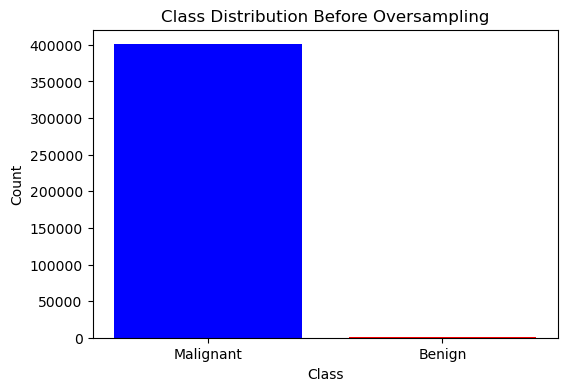

In [51]:
# Count class instances before oversampling
class_counts = metadata['target'].value_counts()

# Plot class distribution before oversampling
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])
plt.xticks([0, 1], ['Malignant', 'Benign'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution Before Oversampling")
plt.show()

#### Image Sample With Properties

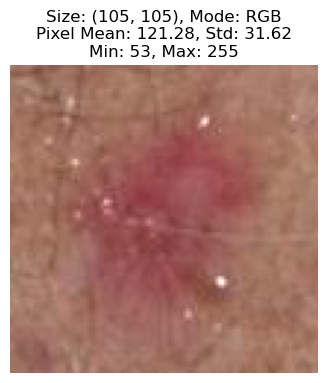

In [ ]:
sample_image_path = r"isic-2024-challenge\train-image\image\ISIC_9996602.jpg"
img = Image.open(sample_image_path)

# Get image properties
image_size = img.size
image_mode = img.mode

# Convert image to numpy array for pixel statistics
img_array = np.array(img)
pixel_mean = img_array.mean()
pixel_std = img_array.std()
pixel_min = img_array.min()
pixel_max = img_array.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.title(f"Size: {image_size}, Mode: {image_mode}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}, Max: {pixel_max}")
plt.show()

#### Process Image Dataset
- This code preprocesses, oversamples, and prepares the ISIC 2024 image dataset for training. It loads metadata, maps image filenames to labels, and addresses class imbalance by generating 30 augmented copies of minority-class images. The dataset is then split (80-20) into training and testing sets, converted into TensorFlow datasets, and preprocessed image normalization in parallel. To maintain class balance, training batches follow a 90% majority - 10% minority ratio, and datasets are batched, repeated, and merged. This setup ensures efficient training on a balanced dataset.

In [ ]:
# Load metadata
metadata = pd.read_csv(r"isic-2024-challenge\train-metadata.csv", low_memory=False)
image_dir = r"isic-2024-challenge\train-image\image"
processed_dir = r"isic-2024-challenge\processed_images"

# create DIR for run once use many times
os.makedirs(processed_dir, exist_ok=True)

# Create a mapping from image filenames to labels
labels = metadata[['isic_id', 'target']].copy()
labels['isic_id'] = labels['isic_id'].apply(lambda x: x + '.jpg')
image_to_label = dict(zip(labels['isic_id'], labels['target']))

# Create a list of image file paths and their corresponding labels
image_paths = [os.path.join(image_dir, img_id) for img_id in labels['isic_id']]
image_labels = [image_to_label[img_id] for img_id in labels['isic_id']]
new_labels = pd.DataFrame({'isic_id': image_paths, 'target': image_labels})


# Seperate the minority and majority classes
minority_class = new_labels[labels['target'] == 1]
majority_class = new_labels[labels['target'] == 0]

# Oversample the minority class
n = 30
for img_id in minority_class['isic_id']:
    img = Image.open(img_id)
    img_name = os.path.basename(img_id).split('.')[0]
    new_images = image_multiplier(processed_dir, img_name, img, n)
    new_labels = [1] * len(new_images)
    minority_class = pd.concat([minority_class, pd.DataFrame({'isic_id': new_images, 'target': new_labels})], ignore_index=True)


# Split minority and majority classes into train and test sets (80-20 split)
minority_train, minority_test = train_test_split(minority_class, test_size=0.2, random_state=42)
majority_train, majority_test = train_test_split(majority_class, test_size=0.2, random_state=42)

# Reset indices
minority_train = minority_train.reset_index(drop=True)
minority_test = minority_test.reset_index(drop=True)
majority_train = majority_train.reset_index(drop=True)
majority_test = majority_test.reset_index(drop=True)

# Create TensorFlow datasets for train and test sets
def create_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return dataset

# Training datasets
minority_train_dataset = create_dataset(minority_train['isic_id'], minority_train['target'])
majority_train_dataset = create_dataset(majority_train['isic_id'], majority_train['target'])

# Testing datasets
minority_test_dataset = create_dataset(minority_test['isic_id'], minority_test['target'])
majority_test_dataset = create_dataset(majority_test['isic_id'], majority_test['target'])


# Parallelize image loading and preprocessing
minority_train_dataset = minority_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
majority_train_dataset = majority_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

minority_test_dataset = minority_test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
majority_test_dataset = majority_test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch the dataset
batch_size = 1000
majority_ratio = 0.9
minority_ratio = 0.1
num_batches = 10

majority_batch_size = int(batch_size * majority_ratio)
minority_batch_size = int(batch_size * minority_ratio)

minority_train_dataset = minority_train_dataset.repeat()
majority_train_dataset = majority_train_dataset.repeat()


minority_train_dataset = minority_train_dataset.batch(minority_batch_size)
majority_train_dataset = majority_train_dataset.batch(majority_batch_size)

# Combine the minority and majority class train Batches
train_dataset = tf.data.Dataset.zip((minority_train_dataset, majority_train_dataset)).map(lambda x, y: (tf.concat([x[0], y[0]], 0), tf.concat([x[1], y[1]], 0)))
# Combine the minority and majority class test datasets
test_dataset = minority_test_dataset.concatenate(majority_test_dataset)

In [62]:
# Print the first batch
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    

Images shape: (1000, 100, 100, 3)
Labels shape: (1000,)


#### Processed image with propertities

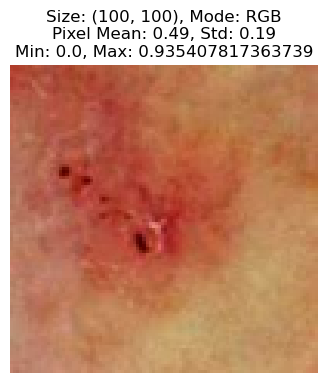

In [78]:
sample_image = images[0].numpy()

# Get image properties
image_size = img.size
image_mode = img.mode

# Convert image to numpy array for pixel statistics
img_array = np.array(sample_image)
pixel_mean = img_array.mean()
pixel_std = img_array.std()
pixel_min = img_array.min()
pixel_max = img_array.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.axis("off")  # Hide axes
plt.title(f"Size: {image_size}, Mode: {image_mode}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}, Max: {pixel_max}")
plt.show()

#### Process Metadata